In [ ]:
import matplotlib.pyplot as plt

from custom_objects.curves import learning_curve
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rfYCcNnmeIoqGxOhC7RA")
project = rf.workspace("joseph-nelson").project("thermal-dogs-and-people")
version = project.version(6)
dataset = version.download("multiclass")

### Gather Data

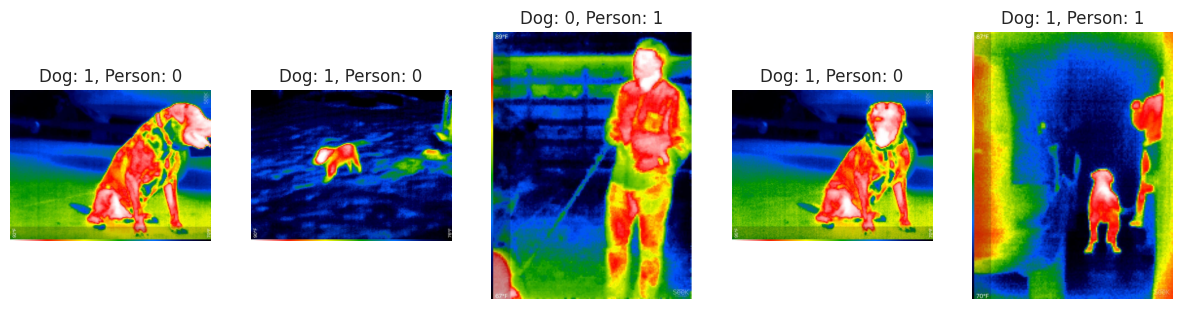

In [149]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Paths to datasets
base_dir = 'Thermal-Dogs-and-People-6'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Loading CSV files
train_labels = pd.read_csv(os.path.join(train_dir, '_classes.csv'))
valid_labels = pd.read_csv(os.path.join(valid_dir, '_classes.csv'))
test_labels = pd.read_csv(os.path.join(test_dir, '_classes.csv'))

# Function to load images based on file names
def load_image(filepath):
    return Image.open(filepath)

# Display sample images from the training set
def display_sample_images(df, image_dir, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (idx, row) in enumerate(df.sample(num_samples).iterrows()):
        img_path = os.path.join(image_dir, row['filename'])
        img = load_image(img_path)
        label = f"Dog: {row[' dog']}, Person: {row[' person']}"

        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

# Display samples from the train dataset
display_sample_images(train_labels, train_dir)

### Preprocessing

InceptionV3 Preprocessed Images:


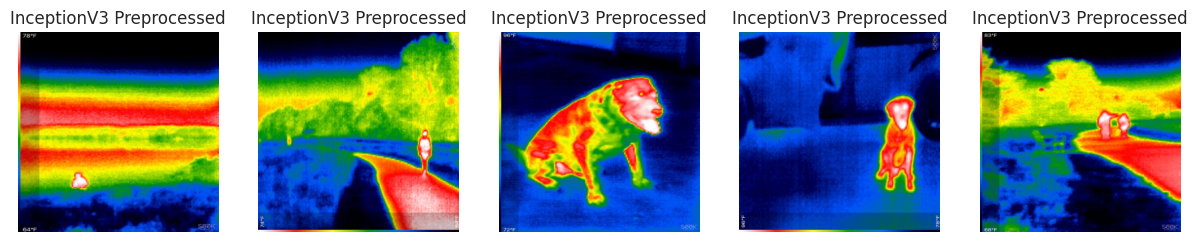

ResNet50 Preprocessed Images:


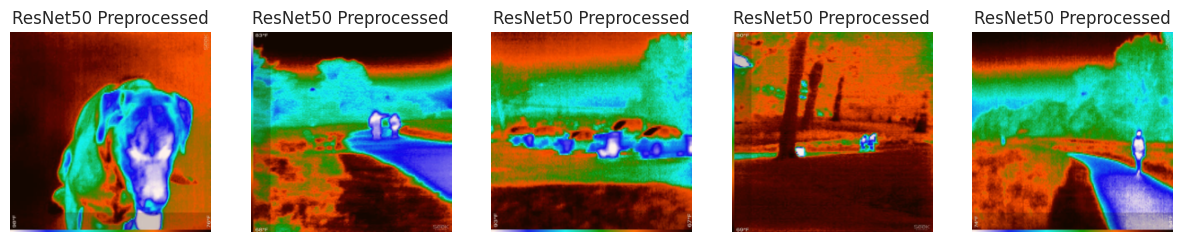

MobileNetV2 Preprocessed Images:


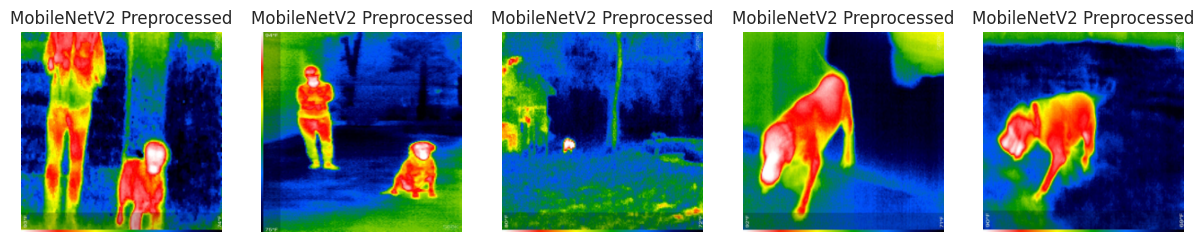

In [150]:
import tensorflow as tf
from tensorflow.keras.applications import (
    InceptionV3, ResNet50, MobileNetV2,
    inception_v3, resnet50, mobilenet_v2
)
import numpy as np

# Define the target image size for each model
TARGET_SIZE_INCEPTION = (299, 299)
TARGET_SIZE_RESNET = (224, 224)
TARGET_SIZE_MOBILENET = (224, 224)

# Functions to preprocess images for each model
def preprocess_image_for_inception(image):
    image = image.resize(TARGET_SIZE_INCEPTION)
    image = tf.keras.preprocessing.image.img_to_array(image)
    return inception_v3.preprocess_input(image)

def preprocess_image_for_resnet(image):
    image = image.resize(TARGET_SIZE_RESNET)
    image = tf.keras.preprocessing.image.img_to_array(image)
    return resnet50.preprocess_input(image)

def preprocess_image_for_mobilenet(image):
    image = image.resize(TARGET_SIZE_MOBILENET)
    image = tf.keras.preprocessing.image.img_to_array(image)
    return mobilenet_v2.preprocess_input(image)

# Function to display preprocessed images
def display_preprocessed_images(df, image_dir, preprocess_func, num_samples=5, model_name="Model"):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (idx, row) in enumerate(df.sample(num_samples).iterrows()):
        img_path = os.path.join(image_dir, row['filename'])
        img = load_image(img_path)
        preprocessed_img = preprocess_func(img)

        # Convert to displayable format if needed
        display_img = (preprocessed_img - preprocessed_img.min()) / (preprocessed_img.max() - preprocessed_img.min())

        axes[i].imshow(display_img)
        axes[i].set_title(f"{model_name} Preprocessed")
        axes[i].axis('off')
    plt.show()

# Display preprocessed images for each model using the training dataset
print("InceptionV3 Preprocessed Images:")
display_preprocessed_images(train_labels, train_dir, preprocess_image_for_inception, model_name="InceptionV3")

print("ResNet50 Preprocessed Images:")
display_preprocessed_images(train_labels, train_dir, preprocess_image_for_resnet, model_name="ResNet50")

print("MobileNetV2 Preprocessed Images:")
display_preprocessed_images(train_labels, train_dir, preprocess_image_for_mobilenet, model_name="MobileNetV2")


In [151]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score

# Define target image sizes for each model
TARGET_SIZE_INCEPTION = (299, 299)
TARGET_SIZE_RESNET = (224, 224)
TARGET_SIZE_MOBILENET = (224, 224)
BATCH_SIZE = 4

# Preprocessing function for each model’s data generator
def create_data_generator(preprocess_func, target_size):
    return ImageDataGenerator(preprocessing_function=preprocess_func).flow_from_dataframe(
        dataframe=train_labels,
        directory=train_dir,
        x_col='filename',
        y_col=[' dog', ' person'],
        target_size=target_size,
        class_mode='raw',
        batch_size=BATCH_SIZE,
        shuffle=True
    )

# Training and validation data generators
train_gen_inception = create_data_generator(inception_preprocess, TARGET_SIZE_INCEPTION)
train_gen_resnet = create_data_generator(resnet_preprocess, TARGET_SIZE_RESNET)
train_gen_mobilenet = create_data_generator(mobilenet_preprocess, TARGET_SIZE_MOBILENET)

valid_gen_inception = create_data_generator(inception_preprocess, TARGET_SIZE_INCEPTION)
valid_gen_resnet = create_data_generator(resnet_preprocess, TARGET_SIZE_RESNET)
valid_gen_mobilenet = create_data_generator(mobilenet_preprocess, TARGET_SIZE_MOBILENET)

test_gen_inception = create_data_generator(inception_preprocess, TARGET_SIZE_INCEPTION)
test_gen_resnet = create_data_generator(resnet_preprocess, TARGET_SIZE_RESNET)
test_gen_mobilenet = create_data_generator(mobilenet_preprocess, TARGET_SIZE_MOBILENET)


Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.
Found 142 validated image filenames.


### Shortlisting Models

In [152]:
FREEZE_TOP_N = -1
EPOCHS = 15
# Helper function to create model with frozen layers
def create_model(base_model, freeze_top_n, input_shape):
    # Freeze the top n layers
    for layer in base_model.layers[:freeze_top_n]:
        layer.trainable = False
    for layer in base_model.layers[freeze_top_n:]:
        layer.trainable = True

    # Adding custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(2, activation='sigmoid')(x)  # 2 nodes for 'dog' and 'person' labels with sigmoid activation
    model = Model(inputs=base_model.input, outputs=output)
    return model

from sklearn.metrics import accuracy_score, recall_score

import matplotlib.pyplot as plt

def train_and_return_model(model, train_gen, valid_gen, model_name):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model and capture the history
    history = model.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, verbose=2)

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


### Baseline Training

#### InceptionV3

Training InceptionV3...
Epoch 1/15


/home/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 - 10s - 284ms/step - accuracy: 0.7183 - loss: 0.5899 - val_accuracy: 0.7817 - val_loss: 0.3706
Epoch 2/15
36/36 - 0s - 14ms/step - accuracy: 0.8099 - loss: 0.3342 - val_accuracy: 0.8662 - val_loss: 0.2536
Epoch 3/15
36/36 - 1s - 14ms/step - accuracy: 0.8732 - loss: 0.2446 - val_accuracy: 0.8099 - val_loss: 0.2027
Epoch 4/15
36/36 - 1s - 15ms/step - accuracy: 0.8521 - loss: 0.1907 - val_accuracy: 0.9296 - val_loss: 0.1588
Epoch 5/15
36/36 - 1s - 15ms/step - accuracy: 0.8662 - loss: 0.1390 - val_accuracy: 0.9437 - val_loss: 0.1416
Epoch 6/15
36/36 - 1s - 15ms/step - accuracy: 0.8803 - loss: 0.1165 - val_accuracy: 0.9225 - val_loss: 0.1025
Epoch 7/15
36/36 - 1s - 15ms/step - accuracy: 0.8662 - loss: 0.0928 - val_accuracy: 0.8380 - val_loss: 0.0791
Epoch 8/15
36/36 - 1s - 14ms/step - accuracy: 0.8662 - loss: 0.0793 - val_accuracy: 0.8592 - val_loss: 0.0631
Epoch 9/15
36/36 - 1s - 15ms/step - accuracy: 0.8592 - loss: 0.0690 - val_accuracy: 0.8592 - val_loss: 0.0522
Epoch 10/15
36/36 -

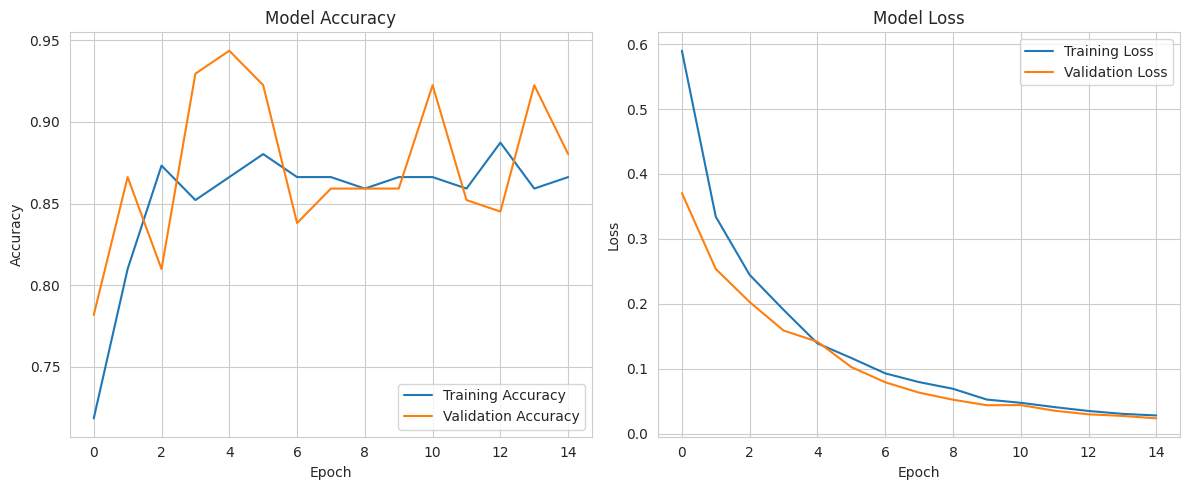

In [153]:
# Load models, configure layers, and train
print("Training InceptionV3...")
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
inception_model = create_model(inception_base, FREEZE_TOP_N, (299, 299, 3))
inception_model = train_and_return_model(inception_model, train_gen_inception, valid_gen_inception, "InceptionV3")


#### ResNet50


Training ResNet50...
Epoch 1/15


/home/thory/miniconda3/envs/tiny-ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 - 6s - 172ms/step - accuracy: 0.6972 - loss: 0.5090 - val_accuracy: 0.9155 - val_loss: 0.2339
Epoch 2/15
36/36 - 1s - 15ms/step - accuracy: 0.8732 - loss: 0.1809 - val_accuracy: 0.8521 - val_loss: 0.1054
Epoch 3/15
36/36 - 1s - 15ms/step - accuracy: 0.8521 - loss: 0.1011 - val_accuracy: 0.9085 - val_loss: 0.0780
Epoch 4/15
36/36 - 0s - 14ms/step - accuracy: 0.8732 - loss: 0.0696 - val_accuracy: 0.8169 - val_loss: 0.0506
Epoch 5/15
36/36 - 1s - 15ms/step - accuracy: 0.8592 - loss: 0.0487 - val_accuracy: 0.8592 - val_loss: 0.0375
Epoch 6/15
36/36 - 1s - 15ms/step - accuracy: 0.8521 - loss: 0.0376 - val_accuracy: 0.9225 - val_loss: 0.0301
Epoch 7/15
36/36 - 1s - 15ms/step - accuracy: 0.8662 - loss: 0.0307 - val_accuracy: 0.9155 - val_loss: 0.0241
Epoch 8/15
36/36 - 1s - 15ms/step - accuracy: 0.8521 - loss: 0.0224 - val_accuracy: 0.8239 - val_loss: 0.0182
Epoch 9/15
36/36 - 0s - 14ms/step - accuracy: 0.8592 - loss: 0.0197 - val_accuracy: 0.8380 - val_loss: 0.0147
Epoch 10/15
36/36 - 

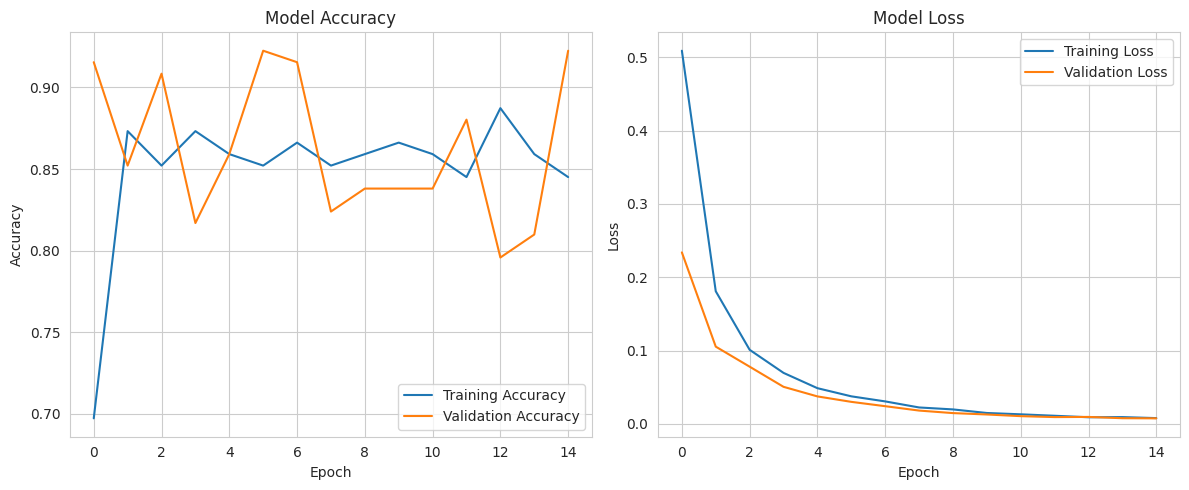

In [154]:
print("\nTraining ResNet50...")
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = create_model(resnet_base, FREEZE_TOP_N, (224, 224, 3))
resnet_model = train_and_return_model(resnet_model, train_gen_resnet, valid_gen_resnet, "ResNet50")

#### MobileNetV2


Training MobileNetV2...
Epoch 1/15
36/36 - 5s - 140ms/step - accuracy: 0.6901 - loss: 0.4930 - val_accuracy: 0.9085 - val_loss: 0.2290
Epoch 2/15
36/36 - 0s - 14ms/step - accuracy: 0.8451 - loss: 0.1899 - val_accuracy: 0.9085 - val_loss: 0.1245
Epoch 3/15
36/36 - 0s - 13ms/step - accuracy: 0.8451 - loss: 0.1089 - val_accuracy: 0.8099 - val_loss: 0.0796
Epoch 4/15
36/36 - 0s - 13ms/step - accuracy: 0.8380 - loss: 0.0752 - val_accuracy: 0.9296 - val_loss: 0.0591
Epoch 5/15
36/36 - 0s - 13ms/step - accuracy: 0.8662 - loss: 0.0491 - val_accuracy: 0.8239 - val_loss: 0.0377
Epoch 6/15
36/36 - 0s - 13ms/step - accuracy: 0.8451 - loss: 0.0367 - val_accuracy: 0.8451 - val_loss: 0.0288
Epoch 7/15
36/36 - 0s - 14ms/step - accuracy: 0.8380 - loss: 0.0286 - val_accuracy: 0.8732 - val_loss: 0.0239
Epoch 8/15
36/36 - 0s - 13ms/step - accuracy: 0.8239 - loss: 0.0230 - val_accuracy: 0.8944 - val_loss: 0.0201
Epoch 9/15
36/36 - 0s - 13ms/step - accuracy: 0.8521 - loss: 0.0186 - val_accuracy: 0.8239 - v

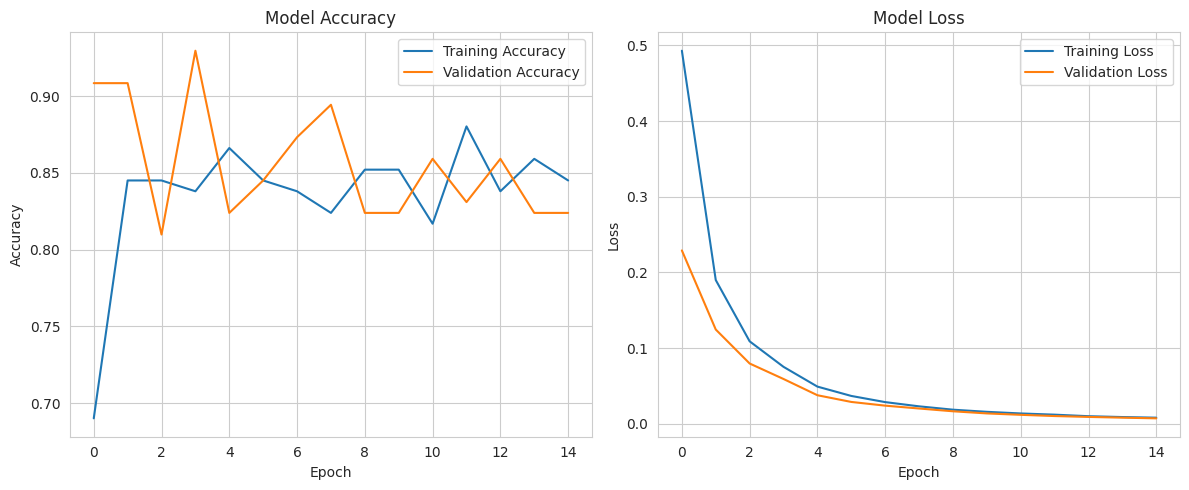

In [155]:
print("\nTraining MobileNetV2...")
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model = create_model(mobilenet_base, FREEZE_TOP_N, (224, 224, 3))
mobilenet_model = train_and_return_model(mobilenet_model, train_gen_mobilenet, valid_gen_mobilenet, "MobileNetV2")

### Pre-tuning Evaluation

In [53]:
mobile_accuracy = mobilenet_model.evaluate(test_gen_mobilenet, verbose=2)[1]
resnet_accuracy = resnet_model.evaluate(test_gen_resnet, verbose=2)[1]
inception_accuracy = inception_model.evaluate(test_gen_inception, verbose=2)[1]

36/36 - 0s - 7ms/step - accuracy: 0.8521 - loss: 0.0077
36/36 - 0s - 7ms/step - accuracy: 0.9085 - loss: 0.0074
36/36 - 0s - 7ms/step - accuracy: 0.8732 - loss: 0.0257


In [54]:
print(f'InceptionV3 Accuracy: {inception_accuracy*100:.2f}%\n ResNet50 Accuracy: {resnet_accuracy*100:.2f}%\n MobileNetV2 Accuracy: {mobile_accuracy*100:.2f}%')

InceptionV3 Accuracy: 87.32%
 ResNet50 Accuracy: 90.85%
 MobileNetV2 Accuracy: 85.21%


#### Save Models

In [56]:
resnet_model.save("vaibhav_resnet.keras")
mobilenet_model.save("vaibhav_mobilenet.keras")
inception_model.save("vaibhav_inception.keras")

#### Load Models

In [125]:
resnet_model = tf.keras.models.load_model("vaibhav_resnet.keras")
mobilenet_model = tf.keras.models.load_model("vaibhav_mobilenet.keras")
inception_model = tf.keras.models.load_model("vaibhav_inception.keras")

### Finetuning MobileNet

In [64]:
import tensorflow as tf
from tensorflow.keras import regularizers

def finetune_model(
        model,
        train_gen,
        valid_gen,
        optimizer='adam',
        learning_rate=0.0001,
        epochs=10,
        regularizer=None,
        loss_function='binary_crossentropy',
        metrics=['accuracy'],
        fine_tune_layers=None  
):
    """
    Fine-tune a pre-trained model with specified hyperparameters.

    Parameters:
    - model: Pre-trained model to fine-tune.
    - train_gen: Training data generator.
    - valid_gen: Validation data generator.
    - optimizer: Optimizer to use (default 'adam').
    - learning_rate: Learning rate for the optimizer (default 0.0001).
    - epochs: Number of epochs to train (default 10).
    - regularizer: Optional regularizer to apply to layers (e.g., l2 or l1 regularizer).
    - loss_function: Loss function to use (default 'binary_crossentropy').
    - metrics: List of metrics to monitor during training (default ['accuracy']).
    - fine_tune_layers: Index or list of layers to unfreeze for fine-tuning.
    
    Returns:
    - The fine-tuned model.
    """

    # If specified, unfreeze some layers for fine-tuning
    if fine_tune_layers is not None:
        if isinstance(fine_tune_layers, int):
            # Unfreeze all layers from the specified index onward
            for layer in model.layers[fine_tune_layers:]:
                layer.trainable = True
        elif isinstance(fine_tune_layers, list):
            # Unfreeze specific layers by name
            for layer in model.layers:
                if layer.name in fine_tune_layers:
                    layer.trainable = True
        else:
            raise ValueError("fine_tune_layers should be an integer or a list of layer names.")

    # Apply regularizer to applicable layers if specified
    if regularizer is not None:
        for layer in model.layers:
            if hasattr(layer, 'kernel_regularizer'):
                layer.kernel_regularizer = regularizer

    # Compile the model with specified optimizer, learning rate, and loss function
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer specified. Use 'adam', 'sgd', or 'rmsprop'.")

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    # Fine-tune the model
    model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=2)

    return model


In [141]:
from tensorflow.keras.regularizers import l2
import copy

# Fine-tune a model
mobilenet_model_tuned = finetune_model(
    model=mobilenet_model,
    train_gen=train_gen_mobilenet,
    valid_gen=valid_gen_mobilenet,
    optimizer='adam',
    learning_rate=0.0001,
    epochs=30,
    regularizer=l2(0.0001),
    fine_tune_layers=-1
)

Epoch 1/30
36/36 - 5s - 145ms/step - accuracy: 0.9507 - loss: 1.2709e-08 - val_accuracy: 0.9507 - val_loss: 1.2278e-08
Epoch 2/30
36/36 - 0s - 13ms/step - accuracy: 0.9507 - loss: 1.2174e-08 - val_accuracy: 0.9507 - val_loss: 1.1703e-08
Epoch 3/30
36/36 - 0s - 13ms/step - accuracy: 0.9507 - loss: 1.1537e-08 - val_accuracy: 0.9507 - val_loss: 1.1195e-08
Epoch 4/30
36/36 - 0s - 13ms/step - accuracy: 0.9507 - loss: 1.1152e-08 - val_accuracy: 0.9507 - val_loss: 1.0733e-08
Epoch 5/30
36/36 - 0s - 13ms/step - accuracy: 0.9507 - loss: 1.0580e-08 - val_accuracy: 0.9507 - val_loss: 1.0249e-08
Epoch 6/30
36/36 - 0s - 14ms/step - accuracy: 0.9507 - loss: 1.0120e-08 - val_accuracy: 0.9507 - val_loss: 9.8395e-09
Epoch 7/30
36/36 - 0s - 13ms/step - accuracy: 0.9507 - loss: 9.7751e-09 - val_accuracy: 0.9507 - val_loss: 9.4957e-09
Epoch 8/30
36/36 - 0s - 13ms/step - accuracy: 0.9507 - loss: 9.3956e-09 - val_accuracy: 0.9507 - val_loss: 9.1473e-09
Epoch 9/30
36/36 - 1s - 14ms/step - accuracy: 0.9507 - 

In [146]:
final_accuracy = mobilenet_model_tuned.evaluate(test_gen_mobilenet, verbose=2)[1]*100

36/36 - 0s - 7ms/step - accuracy: 0.9648 - loss: 5.0277e-09


In [148]:
mobilenet_model_tuned.save("vaibhav_mobilenet_BEST.keras")

In [147]:
print('MobileNet Final Accuracy = ', final_accuracy, ' %')

MobileNet Final Accuracy =  96.47887349128723  %
